# Character Segmentation
Demonstrating usage of pretrained machine learning models.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

import ipywidgets as widgets
from IPython.display import display, clear_output

sys.path.append('src')
from ocr import page, words
from ocr.normalization import word_normalization
from ocr.tfhelpers import Model
from ocr.helpers import implt, resize

plt.rcParams['figure.figsize'] = (12.0, 9.0)

### Gloval Variables

In [2]:
IMG = "love"

## Load Image and Separate Words

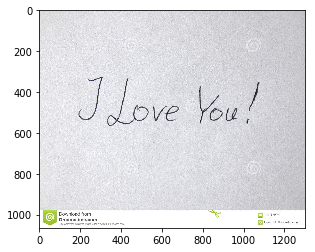

In [3]:
image = cv2.cvtColor(cv2.imread("data/pages/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

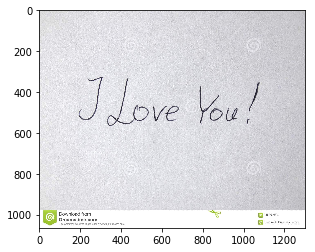

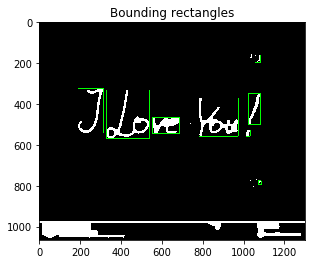

In [4]:
# Crop image and get bounding boxes of words
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Load Trained Model

In [5]:
char_segmentation = Model('models/gap-clas/RNN/Bi-RNN-new', 'prediction')
print("Successfully loaded.")

W0626 20:55:30.494574 12424 deprecation_wrapper.py:119] From src\ocr\tfhelpers.py:20: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0626 20:55:30.506946 12424 deprecation_wrapper.py:119] From src\ocr\tfhelpers.py:22: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0626 20:55:31.471328 12424 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Successfully loaded.


## Applying Model

In [6]:
class Cycler:
    """ Cycle through boxes, separate words """
    width = 60
    height = 60
    step = 2
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.actual = image      # Current image of word, drawing lines
        self.actualG = image     # Current slider image, evaluating
        self.nextImg(boxes)
    
    def nextPos(self):
        """ Sliding over image and classifying regions """      
        
        length = (self.actual.shape[1] - self.width) // 2 + 1
        input_seq = np.zeros((1, length, self.height*self.width), dtype=np.float32)
        input_seq[0][:] = [self.actualG[:, loc * self.step:loc * self.step + self.width].flatten()
                           for loc in range(length)]
        
        pred = char_segmentation.eval_feed({
            'inputs:0': input_seq,
            'length:0': [length],
            'keep_prob:0': 1})[0]
        

        # Finalize the gap positions from raw prediction
        gaps = []
        lastGap = 0
        gapCount = 1
        gapPositionSum = self.width / 2
        firstGap = True
        gapBlockFirst = 0
        gapBlockLast = self.width / 2
        
        gapsImage = self.actual.copy()

        for i, p in enumerate(pred):
            if p == 1:
                gapPositionSum += i * self.step + self.width / 2
                gapBlockLast = i * self.step + self.width / 2
                gapCount += 1
                lastGap = 0
                if gapBlockFirst == 0:
                    gapBlockFirst = i * self.step + self.width / 2
            else:
                if gapCount != 0 and lastGap >= 1:
                    if firstGap:
                        gaps.append(int(gapBlockLast))
                        firstGap = False
                    else:
                        gaps.append(int(gapPositionSum // gapCount))
                    gapPositionSum = 0
                    gapCount = 0
                gapBlockFirst = 0
                lastGap += 1
            # Plotting all lines
            cv2.line(self.actual,
                     ((int)(i * self.step + self.width / 2),0),
                     ((int)(i * self.step + self.width / 2),self.height),
                     (int(255-(p*255)), int(p*255), 0), 1)

        # Adding final gap position
        if gapBlockFirst != 0:
            gaps.append(int(gapBlockFirst))
        else:
            gapPositionSum += (len(pred) - 1) * 2 + slider[1]/2
            gaps.append(int(gapPositionSum / (gapCount + 1)))
        
        for gap in gaps:
            cv2.line(gapsImage,
                     ((int)(gap),0),
                     ((int)(gap),
                     self.height), (0,255,0,0.5), 1)
            
        implt(self.actual)
        print("GAPS")
        print(gaps)
        implt(gapsImage)
        

    def nextImg(self, b):
        """ Getting next image from the array """
        clear_output()
        
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)                      
            implt(img, t='Original')
            img = word_normalization(
                img,
                self.height,
                border=False,
                border_size=int(self.width/2),
                hyst_norm=True)
            implt(img, 'gray', 'normalize')
            
            self.actual = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            self.actualG = img         
            
            self.nextPos()
            
            # Printing index for recovery
            print("Index: " + str(self.index))
            
            # Create button for cycling through images
            bNexi = widgets.Button(description="Next Image")
            bNexi.on_click(self.nextImg)
            display(bNexi)
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

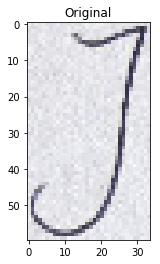

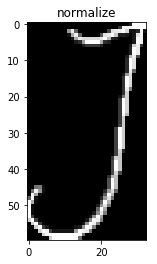

ValueError: negative dimensions are not allowed

In [7]:
# Class cycling through text positions
# Green - Gaps
# Red   - Characters
LAST_INDEX = 6
cycler = Cycler(crop, bBoxes, LAST_INDEX)